## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Number of Car-Images: 8792
Number of Non-Car-Images: 5068
Image data shape = (64, 64, 3)


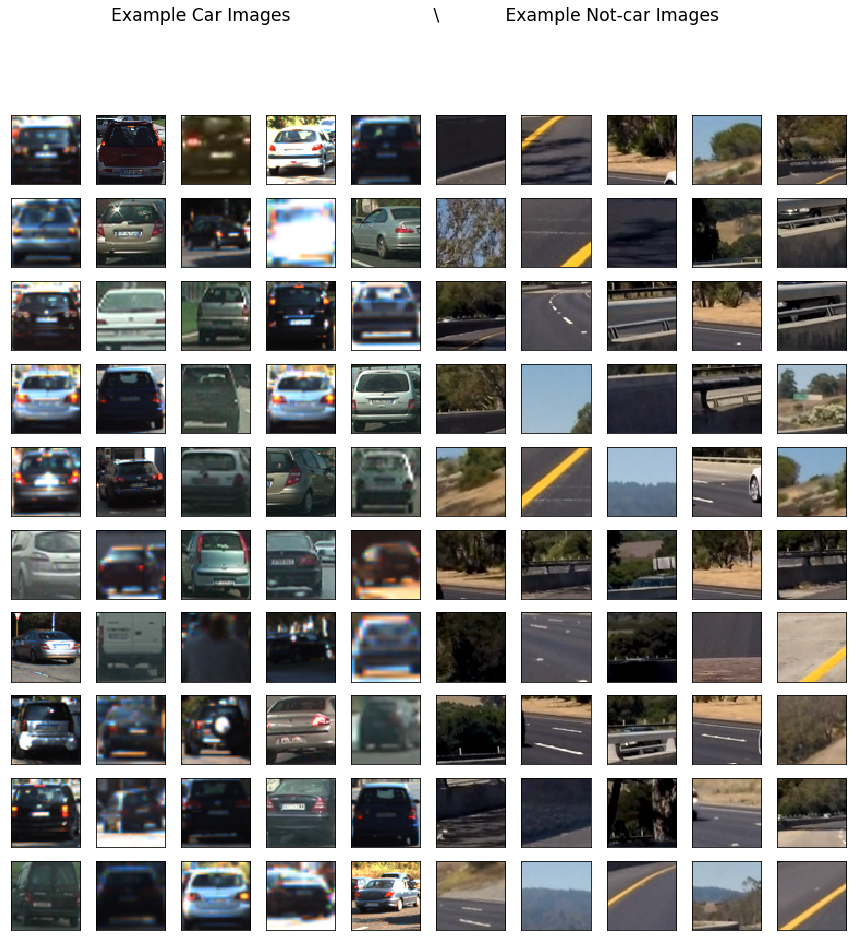

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

%matplotlib inline

PATH_VEHICLE_IMAGES = 'vehicles/'
PATH_NON_VEHICLE_IMAGES = 'non-vehicles/'
images = glob.glob(PATH_VEHICLE_IMAGES + '*/*.png')
cars = []
for image in images:
    cars.append(image)
        
images = glob.glob(PATH_NON_VEHICLE_IMAGES + '*/*.png')
notcars = []
for image in images:
    notcars.append(image)
    
example_car = mpimg.imread(cars[0])
image_shape = example_car.shape

print("Number of Car-Images: {}".format(len(cars)))
print("Number of Non-Car-Images: {}".format(len(notcars)))
print("Image data shape =", image_shape)

### Data exploration visualization code goes here.
f, ax = plt.subplots(10, 10, figsize=(15,15))
f.suptitle('Example Car Images                          \\
            Example Not-car Images', fontsize='xx-large')
cars_indicies = random.sample(range(0, len(cars)), 50)
notcars_indicies = random.sample(range(0, len(notcars)), 50)

for i in range(5):
    for j in range(10):
        example_car = mpimg.imread(cars[cars_indicies[10*i+j]])
        example_notcar = mpimg.imread(notcars[notcars_indicies[10*i+j]])
        ax[j,i].imshow(example_car)
        ax[j,i+5].imshow(example_notcar)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        ax[j,i+5].set_xticks([])
        ax[j,i+5].set_yticks([])

In [2]:
import cv2
from skimage.feature import hog

#hog_desc = cv2.HOGDescriptor((64,64),(16,16),(8,8),(8,8),9)

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
 
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=vis, feature_vector=feature_vec)
        return features
 
def convert_colorspace(image, cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    return feature_image
    
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                           hist_bins=32, orient=9, pix_per_cell=8, 
                           cell_per_block=2, hog_channel=0,
                           spatial_feat = False, hist_feat = False, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_resize = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
        #img_resize = (np.sqrt(img_resize.astype(np.float32)/255)*255).astype(np.uint8)
        file_features = []
        # apply color conversion if other than 'RGB'
        feature_image = convert_colorspace(img_resize, cspace)  
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)    
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                #hog_features = hog_desc.compute(feature_image[:,:,:])
                hog_features = np.ravel(hog_features)      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #hog_features = hog_desc.compute(feature_image[:,:,hog_channel])
            file_features.append(hog_features.flatten())
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


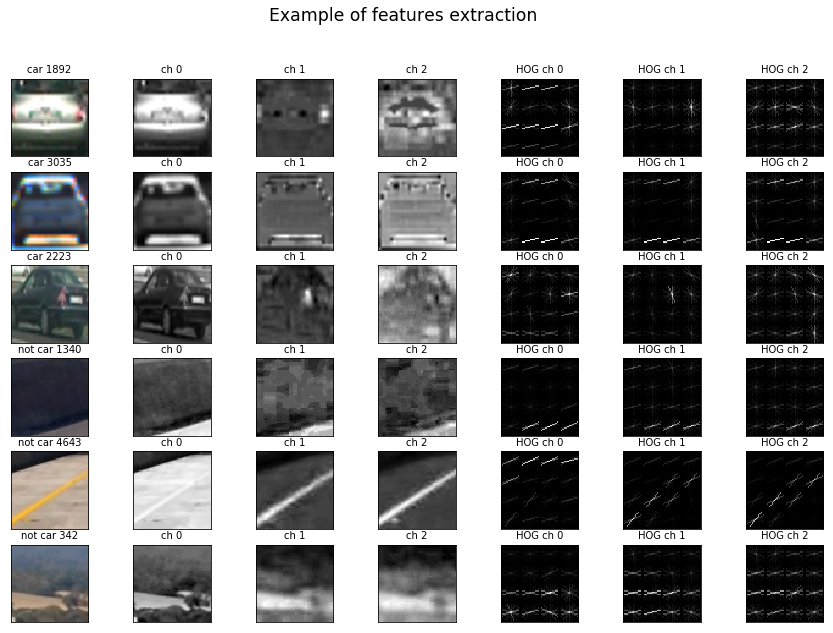

In [3]:
font_size=10
### Tuning of parameters

spatial = (32,32)
histbin = 128
hist_range= (0, 256)
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = False
hist_feat = True
hog_feat = True

### Data exploration visualization code goes here.
f, ax = plt.subplots(6, 7, figsize=(15,10))
f.suptitle('Example of features extraction', fontsize='xx-large')
cars_indicies = random.sample(range(0, len(cars)), 3)
notcars_indicies = random.sample(range(0, len(notcars)), 3)

for i in range(3):
    example_car = mpimg.imread(cars[cars_indicies[i]])
    image = np.copy(example_car)
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
    ax[i,0].imshow(image)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    title = "car {0}".format(cars_indicies[i])
    ax[i,0].set_title(title, fontsize=font_size)
    feature_image = convert_colorspace(image, colorspace)
    for ch in range(3):
        ax[i, ch+1].imshow(feature_image[:,:,ch], cmap='gray')
        ax[i, ch+1].set_xticks([])
        ax[i, ch+1].set_yticks([])
        title = "ch {0}".format(ch)
        ax[i, ch+1].set_title(title, fontsize=font_size)
    for ch in range(3):    
        features, hog_image = get_hog_features(feature_image[:,:,ch], orient, 
                                               pix_per_cell, cell_per_block, vis=True)
        ax[i, ch+4].imshow(hog_image, cmap='gray')
        ax[i, ch+4].set_xticks([])
        ax[i, ch+4].set_yticks([])
        title = "HOG ch {0}".format(ch)
        ax[i, ch+4].set_title(title, fontsize=font_size)
    
for i in range(3):    
    example_notcar = mpimg.imread(notcars[notcars_indicies[i]])
    image = np.copy(example_notcar)
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
    ax[i+3, 0].imshow(image)
    ax[i+3, 0].set_xticks([])
    ax[i+3, 0].set_yticks([])
    title = "not car {0}".format(notcars_indicies[i])
    ax[i+3, 0].set_title(title, fontsize=font_size)
    feature_image = convert_colorspace(image, colorspace)
    for ch in range(3):
        ax[i+3, ch+1].imshow(feature_image[:,:,ch], cmap='gray')
        ax[i+3, ch+1].set_xticks([])
        ax[i+3, ch+1].set_yticks([])
        title = "ch {0}".format(ch)
        ax[i+3, ch+1].set_title(title, fontsize=font_size)
    for ch in range(3):    
        features, hog_image = get_hog_features(feature_image[:,:,ch], orient, 
                                               pix_per_cell, cell_per_block, vis=True)
        ax[i+3, ch+4].imshow(hog_image, cmap='gray')
        ax[i+3, ch+4].set_xticks([])
        ax[i+3, ch+4].set_yticks([])
        title = "HOG ch {0}".format(ch)
        ax[i+3, ch+4].set_title(title, fontsize=font_size)

In [4]:
import time
from sklearn import svm, grid_search, datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

t=time.time()
car_features = extract_features(cars, cspace=colorspace, 
                        spatial_size=spatial,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
notcar_features = extract_features(notcars, cspace=colorspace, 
                        spatial_size=spatial,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print (X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler(copy=False)
X_scaler.fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.1

105.66 Seconds to extract features...
(13860, 1356)
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1356


In [5]:
# Check the training time for the SVC
t=time.time()
# Use a linear SVC 
svc = LinearSVC(C=0.003, dual=False, max_iter=5)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9989
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.]
For these 100 labels:  [ 1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.]
0.021 Seconds to predict 100 labels with SVC


I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


False negative samples:  3
False positive samples:  0


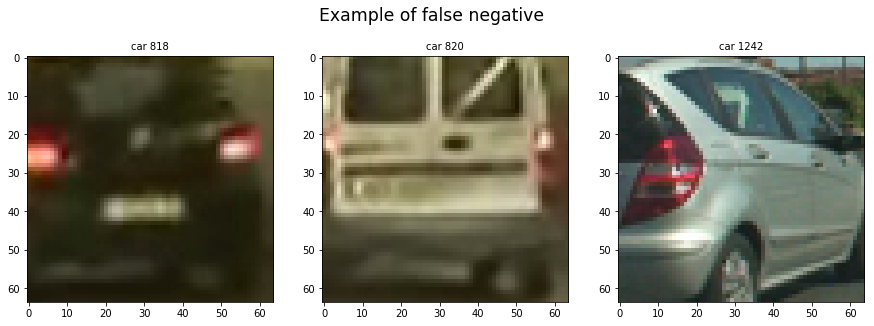

In [6]:
false_positive = []
false_negative = []
cars_features = extract_features(cars, cspace=colorspace, 
                        spatial_size=spatial,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

notcars_features = extract_features(notcars, cspace=colorspace, 
                        spatial_size=spatial,
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
for i in range(8792):
    car_features = X_scaler.transform(cars_features[i].reshape(1,-1))
    prediction = svc.predict(car_features)
    if (prediction == 0):
        false_negative.append(i)
for i in range(5068):        
    notcar_features = X_scaler.transform(notcars_features[i].reshape(1,-1))
    prediction = svc.predict(notcar_features)
    if (prediction == 1):
        false_positive.append(i)    
print('False negative samples: ', len(false_negative))
print('False positive samples: ', len(false_positive))
if (len(false_negative)>0):
    f, ax = plt.subplots(1, len(false_negative), figsize=(15,5))
    f.suptitle('Example of false negative', fontsize='xx-large')
    for i in range(len(false_negative)):
         if((i)<len(false_negative)):
            image = mpimg.imread(cars[false_negative[i]])
            ax[i].imshow(image)
            title = "car {0}".format(false_negative[i])
            ax[i].set_title(title, fontsize=font_size)
if (len(false_positive)>0):        
    f, ax = plt.subplots(1, len(false_positive), figsize=(15,5))
    f.suptitle('Example of false positive', fontsize='xx-large')
    for i in range(len(false_positive)):     
        if((i)<len(false_positive)):
            image = mpimg.imread(notcars[false_positive[i]])
            ax[i].imshow(image)
            title = "notcar {0}".format(false_positive[i])
            ax[i].set_title(title, fontsize=font_size)

## 2. Search for vehicles on image

### 2.1 Sliding Window Implementation

In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
            #hog_features = hog_desc.compute(feature_image[:,:,hog_channel])
        # Append features to list
        img_features.append(hog_features.flatten())

    # Return features
    return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_LINEAR)      
        #test_img = (np.sqrt(test_img.astype(np.float32)/255)*255).astype(np.uint8)
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows  

Number of windows: 236


I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.4862 Seconds to process one image searching
31 Number of hot windows


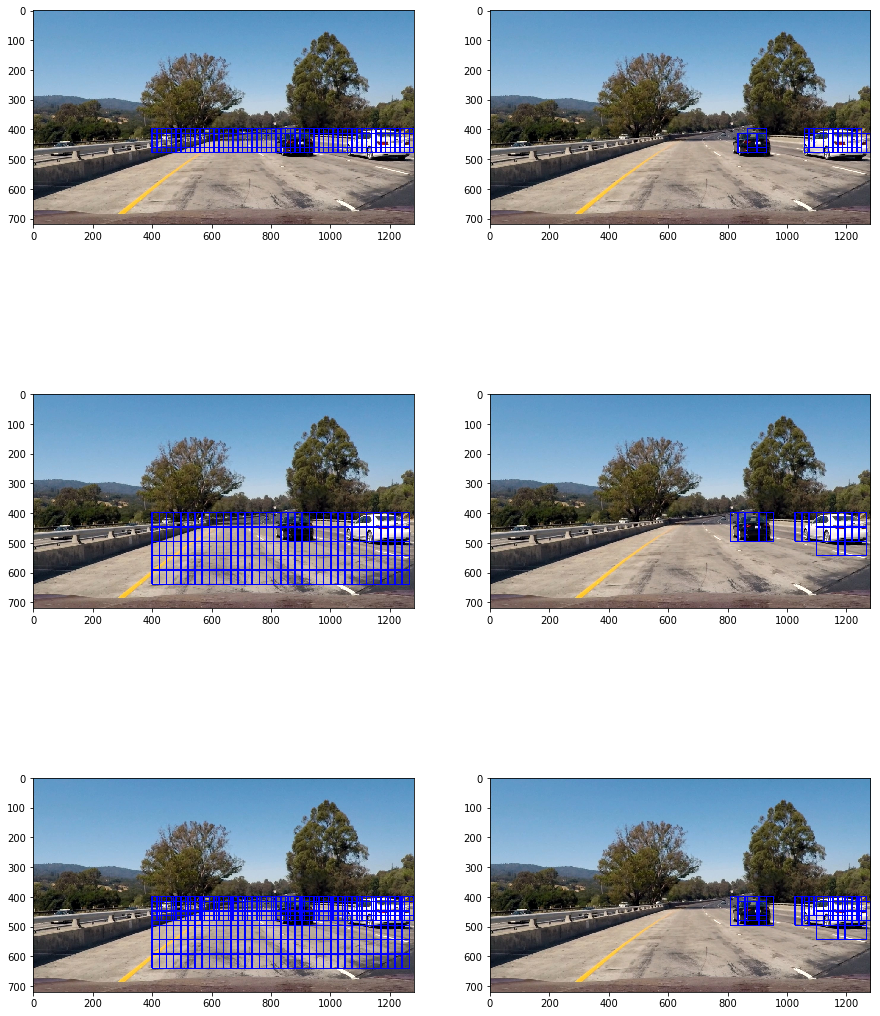

In [8]:
filenames = glob.glob('test_images/*.jpg')
image = mpimg.imread(filenames[0])
img = np.copy(image)
img = img.astype(np.float32)/255
windows = [0,0]
windows[0] = slide_window(img, x_start_stop=[400, 1280], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows[1] = slide_window(img, x_start_stop=[400, 1280], y_start_stop=[400, 650], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.5))
rects = []
rects.append(windows[0])
rects.append(windows[1])
rectangles = [item for sublist in rects for item in sublist] 
print ('Number of windows:', len(rectangles))

f, ax = plt.subplots(3,2, figsize=(15,20))
t=time.time()
for i in range(2):
    out_img = draw_boxes(image, windows[i], color=(0, 0, 255), thick=3)
    ax[i][0].imshow(out_img)
    hot_windows = search_windows(img, windows[i], svc, X_scaler, color_space=colorspace, 
                                 spatial_size=spatial, hist_bins=histbin, 
                                 hist_range=hist_range, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    out_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
    ax[i][1].imshow(out_img)
    
out_img = draw_boxes(image, rectangles, color=(0, 0, 255), thick=3)
ax[2][0].imshow(out_img)
hot_windows = search_windows(img, rectangles, svc, X_scaler, color_space=colorspace, 
                                 spatial_size=spatial, hist_bins=histbin, 
                                 hist_range=hist_range, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)
out_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
ax[2][1].imshow(out_img)
print(round(time.time()-t, 5), 'Seconds to process one image searching')    
print(len(hot_windows), 'Number of hot windows')

### 2.2 Haar Cascade Implementation

0.13601 Seconds to process one image searching
0.12901 Seconds to process one image searching
0.13301 Seconds to process one image searching
0.13701 Seconds to process one image searching
0.13901 Seconds to process one image searching
0.14101 Seconds to process one image searching


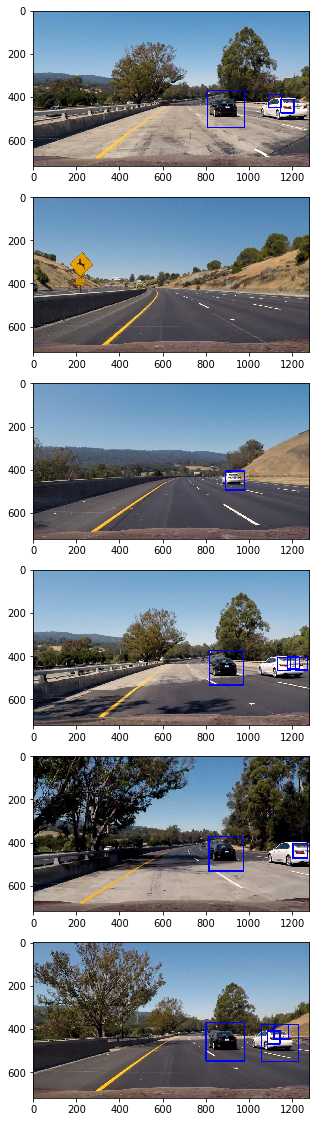

In [9]:
def find_cars_haar_cascade(image, xstart, xstop, ystart, ystop, scaleFactor, 
                           minNeighbors, minSize, maxSize):
    window_list = []
    img = np.copy(image)
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    gray = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    cars = car_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, 
                                        minNeighbors=minNeighbors, 
                                        minSize=minSize, maxSize=maxSize)
    for (x,y,w,h) in cars:                                    
        # Append window position to list
        window_list.append(((x+xstart, y+ystart), (x+w+xstart, y+h+ystart)))
    return window_list

xstart = 400
xstop = 1280
minNeighbors = 3
# Trained XML classifiers describes some features of some object we want to detect
car_cascade = cv2.CascadeClassifier('cars.xml')
filenames = glob.glob('test_images/*.jpg')
f, ax = plt.subplots(len(filenames),1, figsize=(15,20))
for i, filename in enumerate(filenames):
    t=time.time()
    image = mpimg.imread(filename)
    img = np.copy(image)
    ystart = 360
    ystop = 500
    scaleFactor = 1.03
    minSize=(50,50)
    maxSize=(150,150)
    cars =[]
    cars.append(find_cars_haar_cascade(image, xstart, xstop, ystart, ystop, scaleFactor, 
                                  minNeighbors, minSize, maxSize))
    ystart = 360
    ystop = 720
    scaleFactor = 1.1
    minSize=(100,100)
    maxSize=(256,256)
    cars.append(find_cars_haar_cascade(image, xstart, xstop, ystart, ystop, scaleFactor, 
                                  minNeighbors, minSize, maxSize))
    rectangles = [item for sublist in cars for item in sublist] 
    img = draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
    ax[i].imshow(img)
    print(round(time.time()-t, 5), 'Seconds to process one image searching')

### 2.3. HOG Sub-sampling Windows Search Implementation

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(image, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    # array of rectangles where cars were detected
    rectangles = []
    img = np.copy(image)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_colorspace(img_tosearch, cspace=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    #t=time.time()
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print(round(time.time()-t, 5), 'Seconds to process one hog')
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            features = np.concatenate((hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(features.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),
                                  (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))) 
    return rectangles

I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.00906 Seconds to process one image searching
0.97206 Seconds to process one image searching
0.98406 Seconds to process one image searching
1.01306 Seconds to process one image searching
1.07406 Seconds to process one image searching
1.09206 Seconds to process one image searching


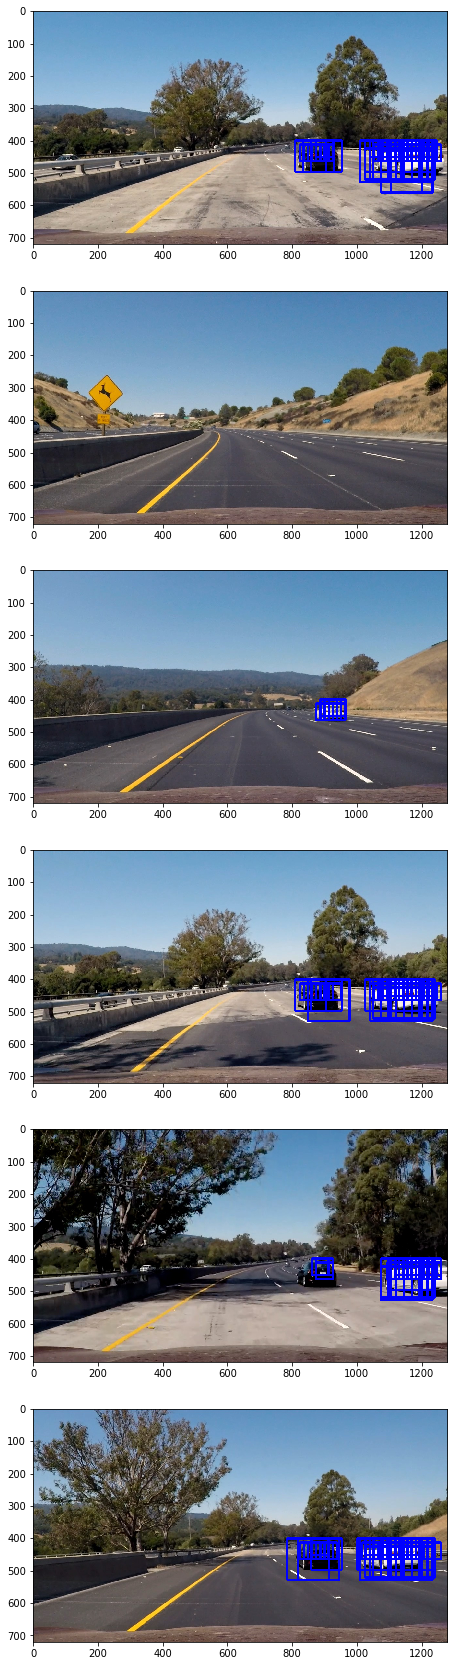

In [11]:
filenames = glob.glob('test_images/*.jpg') 
xstart = 400
xstop = 1280
f, ax = plt.subplots(len(filenames),1, figsize=(15,30))
for i, filename in enumerate(filenames):
    rects = []
    t=time.time()
    image = mpimg.imread(filename)
    img = np.copy(image)
    ystart = 400
    ystop = 480
    scale = 0.8
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    ystart = 400
    ystop = 650
    scale = 1.5
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    ystart = 400
    ystop = 700
    scale = 2
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    rectangles = [item for sublist in rects for item in sublist] 
    out_img = draw_boxes(img, rectangles, color=(0, 0, 255), thick=6)
    ax[i].imshow(out_img)
    print(round(time.time()-t, 5), 'Seconds to process one image searching')

## 3. Heatmap and Label Boxes Implementation

In [12]:
def multiscale_search(image):
    img = np.copy(image)
    rects = []
    ystart = 400
    ystop = 480
    scale = 0.8
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    ystart = 400
    ystop = 650
    scale = 1.5
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    ystart = 400
    ystop = 700
    scale = 2
    rects.append(find_cars(img, colorspace, xstart, xstop, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, 
                           cell_per_block, spatial, histbin))
    rectangles = [item for sublist in rects for item in sublist] 
    return rectangles

def add_heat(image, bbox_list, heatmap = None):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    center_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (((bbox[1][0]-bbox[0][0]) >= 16)and((bbox[1][1]-bbox[0][1]) >= 16)):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        x_center = (bbox[1][0]+bbox[0][0])/2
        y_center = (bbox[1][1]+bbox[0][1])/2
        center_list.append((x_center, y_center))
    # Return the image
    return img, center_list

I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


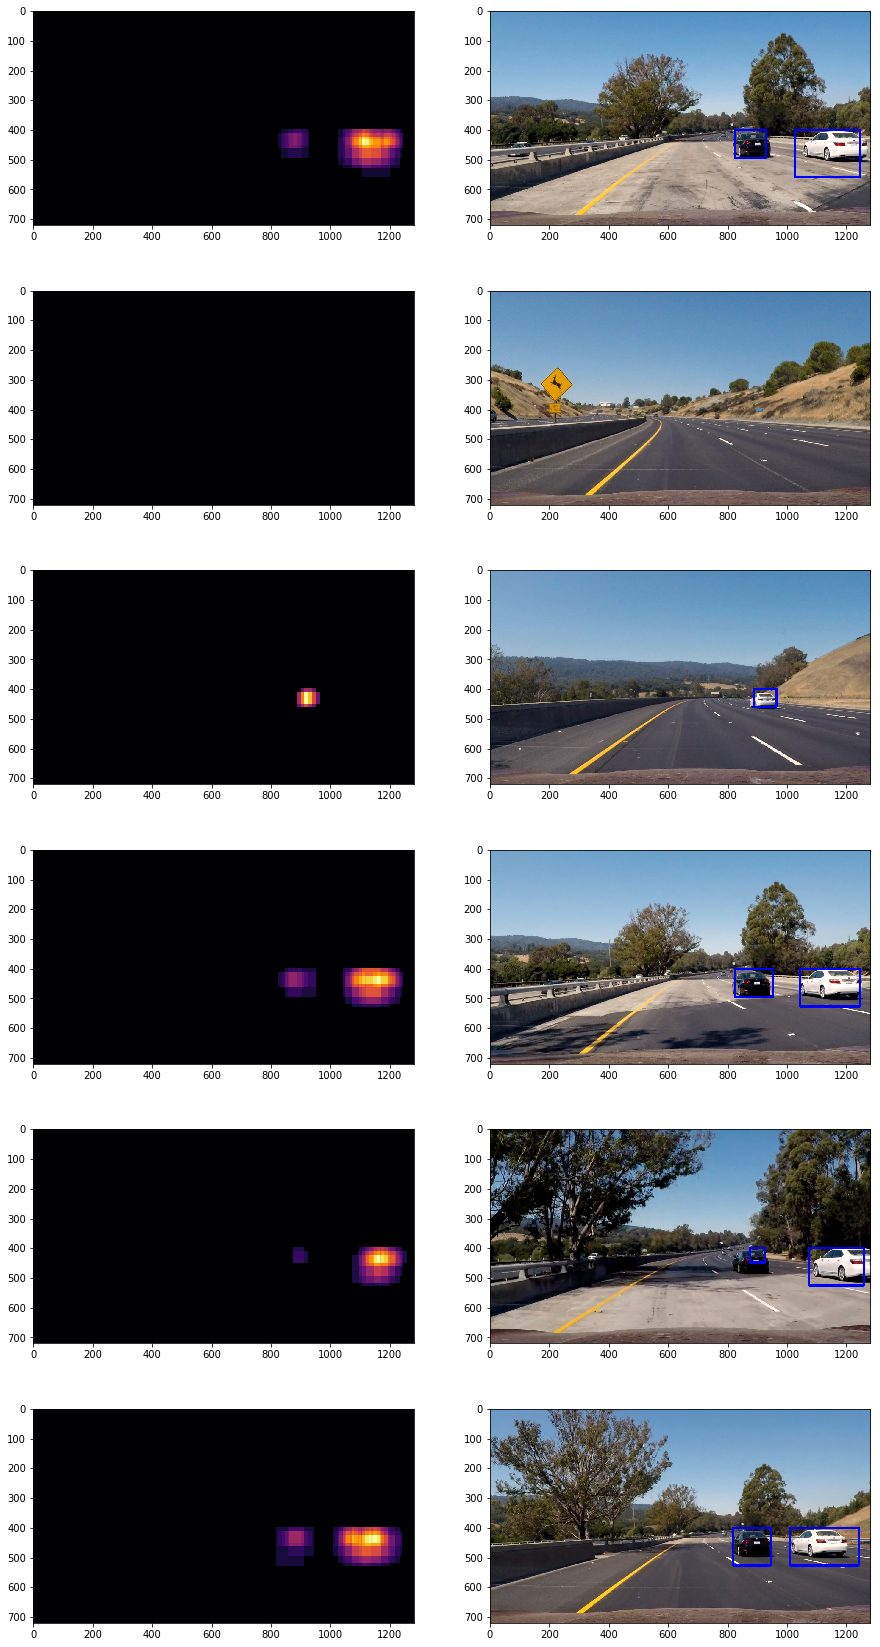

In [13]:
from scipy.ndimage.measurements import label

f, ax = plt.subplots(len(filenames),2, figsize=(15,30))
for i, filename in enumerate(filenames):
    img = mpimg.imread(filename)
    hot_windows = multiscale_search(img)   
    # Add heat to each box in box list
    heat = add_heat(img, hot_windows)   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    ax[i][0].imshow(heatmap, cmap='inferno')
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, centers = draw_labeled_bboxes(np.copy(img), labels)
    ax[i][1].imshow(draw_img)

## 4. Lines Detection Implementation

In [14]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
img = mpimg.imread(filenames[0])        
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print("Calibration finished")

Calibration finished


In [15]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv(img):
    """Applies the HSV transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def yellow_adn_white_filter(hsv_img, gray_img):
    #define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([50,255,255])
    lower_wht = np.array([0,0,220])
    upper_wht = np.array([255,40,255])
    #threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    #bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    filter_img = cv2.bitwise_and(gray_img, full_mask)
    return filter_img

def img_threshold(img, s_thresh=(130, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    mask = np.zeros(img.shape[:-1], dtype=np.uint8)
    mask[:,:][((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))|
              ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]))] = 1
    return mask

def perspective_transforms(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def perspective_view(img):
    img_size = (img.shape[1], img.shape[0])
    point_src = np.float32(
        [(200,720),
         (595, 450), 
         (685,450), 
         (1130,720)])
    point_dst = np.float32(
        [(280,720),
         (280,0),
         (1000, 0),
         (1000,720)])
    M = perspective_transforms(point_src, point_dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    
def perspective_unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    point_src = np.float32(
        [(200,720),
         (595, 450), 
         (685,450), 
         (1130,720)])
    point_dst = np.float32(
        [(280,720),
         (280,0),
         (1000, 0),
         (1000,720)])
    M = perspective_transforms(point_dst, point_src)
    unwarped = cv2.warpPerspective(img, M, img_size)
    return unwarped

def window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[(binary_warped.shape[0]//2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    pixels = [leftx, lefty, rightx, righty]
    # Fit a second order polynomial to each line
    if (len(left_lane_inds)):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = []
    if (len(right_lane_inds)):    
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = []
    return left_fit, right_fit, left_lane_inds, right_lane_inds, pixels

def find_lines(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def gen_polygon(img, left_fitx,right_fitx, ploty):
    warp_zero = np.zeros_like(img)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_pts, right_pts))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    return color_warp

def calc_curvature(pixels):
    #Read pixels list
    leftx = pixels[0]
    lefty = pixels[1]
    rightx = pixels[2]
    righty = pixels[3]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 720
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def calc_offset(left_fitx, right_fitx, image):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]/2
    offset = (veh_pos - middle)*xm_per_pix
    return offset

def show_info(image, left_curverad, right_curverad, offset, num_cars):
    img = np.copy(image)
    # Add message to image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,'Left Curvature: %.2f m'%(left_curverad),(60,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Right Curvature: %.2f m'%(right_curverad),(60,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Offset from Center : %.2f m'%(offset),(60,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Number of tracking cars : %d'%(num_cars),(60,180), font, 1,(255,255,255),2,cv2.LINE_AA)
    return img

## 5. Pipeline Implemetation

In [16]:
import os

def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.jpg' where 
    # x is the frame index
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, '%d.jpg') % count, image)
            count += 1
        else:
            break
    vidcap.release()

video_to_frames('project_video.mp4', 'frames')

I:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


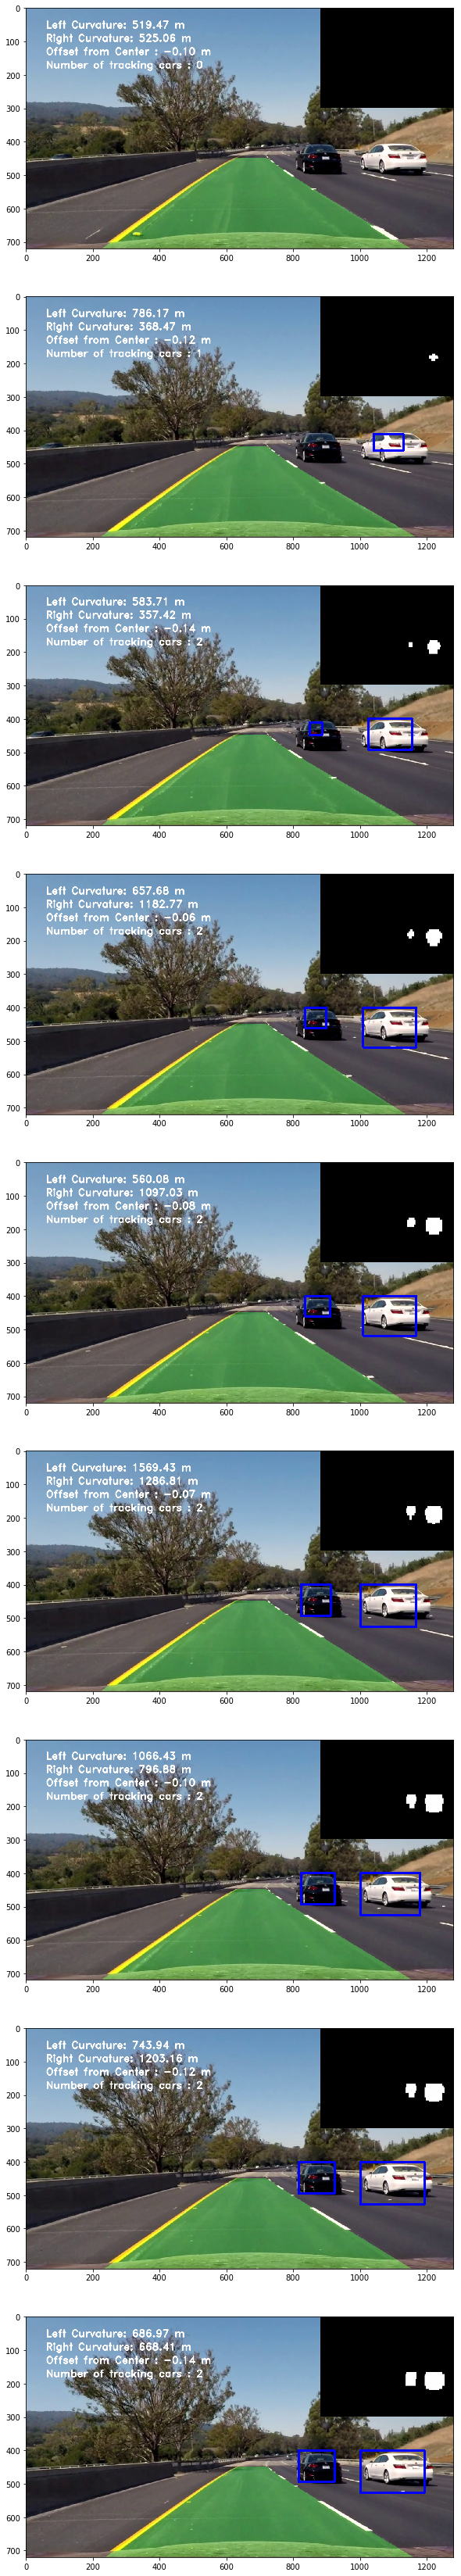

In [17]:
import collections
heatmaps = collections.deque(maxlen=10)

def show_heatmap(image, heatmap, width, height):
    heatmap_cpy = np.copy(50 * heatmap)
    # Normolize the heatmap when displaying    
    heatmap_cpy = np.clip(heatmap_cpy, 0, 255)
    # Resize the image
    resized_heatmap = cv2.resize(heatmap_cpy, (width, height), interpolation=cv2.INTER_AREA)
    # Compose the 3 channel Heatmap
    rgb_heatmap = cv2.merge([resized_heatmap, resized_heatmap, resized_heatmap])
    # Add Heatmap to the Image
    image[0:height,image.shape[1]-width:image.shape[1]] = rgb_heatmap
    return image
    
    
def pipeline(img, heat = None):
    heatmap_vis = True
    line_vis = True
    image = np.copy(img)
    hot_windows = multiscale_search(image)
    # Add heat to each box in box list
    frame_heatmap = add_heat(image, hot_windows)   
    heatmaps.append(frame_heatmap)
    heatmap_sum = sum(heatmaps)
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap_sum,30)
    labels = label(heatmap)
    #find lines routine
    if (line_vis == True):
        dst = cv2.undistort(image, mtx, dist, None, mtx)
        #threshold = img_threshold(dst)
        #dst = bgr_to_rgb(dst)
        image = np.copy(dst)
        #apply grayscale
        gray_img = grayscale(image)
        #apply hsv
        hsv_img = hsv(image)
        #apply yellow and white filter
        filter_img = yellow_adn_white_filter(hsv_img, gray_img)
        binary_warped = perspective_view(filter_img)
        left_fit, right_fit, left_lane_inds, right_lane_inds, pixels = window(binary_warped)
        #left_fit, right_fit = find_lines(binary_warped, left_fit, right_fit)
        if (len(left_fit) > 0)and(len(right_fit) > 0):
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            warped_polygon = gen_polygon(binary_warped, left_fitx, right_fitx, ploty)
            unwarped = perspective_unwarp(warped_polygon)
            image_lines = cv2.addWeighted(dst, 1, unwarped, 0.3, 0)
            left_curverad, right_curverad = calc_curvature(pixels)
            offset = calc_offset(left_fitx, right_fitx, image_lines)
        else:
            print ("lines are not found")
            image_lines = np.copy(dst)
            left_curverad = 0
            right_curverad = 0
            offset = 0
    draw_img, centers = draw_labeled_bboxes(np.copy(image_lines), labels)
    num_cars = (len(centers))
    if (line_vis == True):
        draw_img = show_info(draw_img, left_curverad, right_curverad, offset, num_cars)
    if (heatmap_vis):
        draw_img = show_heatmap(draw_img, heatmap, 400,300)
    return draw_img

def process_image(image):
    result = pipeline(image)
    return result

filenames = glob.glob('frame_images/*.jpg')
f, ax = plt.subplots(len(filenames),1, figsize=(15,60))
for i, filename in enumerate(filenames):
    image = mpimg.imread(filename)
    result = process_image(image)
    ax[i].imshow(result)

## 6. Run pipeline on a video stream

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
project_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:51<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 55.5 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [21]:
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [29:31<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 29min 36s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))